In [1]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean
from scipy import stats as st
from scipy.optimize import fmin_tnc

# Supress warnings
import warnings; warnings.simplefilter('ignore')

## Loading and treating the Adult Dataset

In [2]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [3]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [4]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num', 'gender', 'loss', 'hours']), 1, inplace=True)
income = 2*np.array(income) - 1

In [5]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)

In [6]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

In [7]:
def test(model, qtd_data):
    #Predicting
    y_test_pred = model.predict(X_test[0:qtd_data])
    #y_train_pred = model.predict(X_train)

    # Getting accuracy for the personalized classifier
    #per_train_acc = accuracy_score(Y_train, y_train_pred)
    #per_test_acc = accuracy_score(Y_test[0:qtd_data], y_test_pred)
    
    # L2 score
    #l2_train_acc = mean_squared_error(Y_train, y_train_pred)
    l2_test_acc = mean_squared_error(Y_test[0:qtd_data], y_test_pred)
    
    return l2_test_acc

## Sampling in Convex Hull

In [8]:
def samp_in_hull_after(deln, vols, n):
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())
    
    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

# Implementing Ridge Classifier

In [9]:
def get_ridge(X, Y, alpha):
    return np.linalg.inv(X.T@X + alpha*np.identity(X.shape[1])) @ X.T @ Y

def get_ridge_prediction(parameter, X):
    return X@parameter

def get_ridge_l2_loss(parameter, alpha, X, Y):
    fp = Y - X@parameter
    n = X.shape[0]
    return (np.dot(fp, fp) + alpha * np.dot(parameter, parameter) )

def get_thresholded(pred):
    return 2*(pred > 0)*1 - 1

In [10]:
alpha = 1
np_X = X_train.to_numpy()
omega_hat = get_ridge(np_X, Y_train, alpha)
pred = get_ridge_prediction(omega_hat, np_X)

## Calculating the Rashomon boundary 

In [13]:
center = omega_hat
delta = 0.1 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 1000 #number of directions
qtd_points = np_X.shape[0]
epsilon = 0.1 * qtd_points #Rashomon set size

extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|███████████████████████████████████████| 1000/1000 [06:14<00:00,  2.67it/s]


## Calculating the Convex hull, delaunay triangulation, and triangle volumes 

In [14]:
dims = extremes_l.shape[-1] #get dim
hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
deln = hull[Delaunay(hull).simplices] #get Delunay
vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas

In [15]:
random_model = samp_in_hull_after(deln, vols, 1)

## Getting fair model in the Rashomon set

In [16]:
def fairness_score(parameter, X, Y):
    
    Female_X = X[X['gender_Female'] == 1]
    Female_Y = Y[X['gender_Female'] == 1]
    
    Male_X = X[X['gender_Male'] == 1]
    Male_Y = Y[X['gender_Male'] == 1]

    #Making prediction
    Female_pred = get_thresholded(get_ridge_prediction(parameter, Female_X))
    Male_pred = get_thresholded(get_ridge_prediction(parameter, Male_X))
    
    return np.abs(np.mean(Female_pred == Female_Y) - np.mean(Male_pred == Male_Y))

In [17]:
trials = 3000
fair_par = omega_hat
random_models = samp_in_hull_after(deln, vols, trials)

for i in range(trials):
    if fairness_score(random_models[i], X_train, Y_train) < fairness_score(fair_par, X_train, Y_train):
        fair_par = random_models[i]

In [18]:
 fairness_score(omega_hat, X_train, Y_train)

0.1363591596760535

## Fairness vs Rashomon level tradeoff

In [106]:
center = omega_hat
delta = 0.1 #Size of initial noise
step = 0.0001 #step size for each step in an direction
samples = 1000 #number of directions
qtd_points = np_X.shape[0]
stepp = 0.005
eps = np.arange(0.01, 0.2 + stepp, stepp)
epsilon = eps * qtd_points #Rashomon set size
trials = 10000
extremes_l = np.zeros((samples, center.size))
early_stopping_exploration = 1000
fair_gain = np.zeros((len(eps), trials))
ACC_loss = np.zeros((len(eps), trials))

fair_par = omega_hat

for j in tqdm(range(len(eps))):
    for i in range(samples):
        #Generationg direction
        Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
        Z = Z/np.linalg.norm(Z)
        direction = center + delta * Z
        #loading model
        ct = 1
        while (get_ridge_l2_loss(direction, alpha, np_X, Y_train) - get_ridge_l2_loss(omega_hat, alpha, np_X, Y_train)) < epsilon[j]:
            extremes_l[i, :] = direction
            direction = center + ct*delta*Z
            ct += 1
            if ct==early_stopping_exploration:
                break

    dims = extremes_l.shape[-1] #get dim
    hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
    deln = hull[Delaunay(hull).simplices] #get Delunay
    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas
        
    random_models = samp_in_hull_after(deln, vols, trials)

    for l in range(trials):
        #if fairness_score(random_models[i], X_train, Y_train) < fairness_score(fair_par, X_train, Y_train):
        fair_par = random_models[l]
        fair_gain[j, l] = fairness_score(fair_par, X_train, Y_train)
    
        ACC_loss[j, l] =  np.mean(get_thresholded(get_ridge_prediction(fair_par, X_train)) == Y_train)
    

100%|████████████████████████████████████████| 39/39 [1:56:38<00:00, 179.44s/it]


In [107]:
fair_plt = np.min(fair_gain, axis = 1)

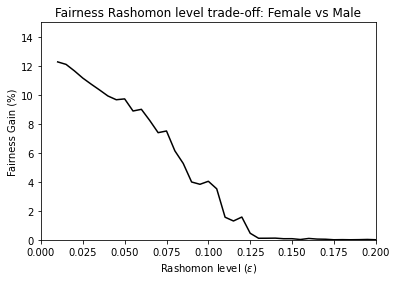

In [108]:
plt.plot(eps, 100*fair_plt, color = 'black')
plt.xlim([0,0.2])
plt.ylim([0, 15])
plt.xlabel(r'Rashomon level ($\epsilon$)')
plt.ylabel(r'Fairness Gain (%)')
plt.title('Fairness Rashomon level trade-off: Female vs Male')
plt.savefig('Fairness_Rashomon _level_trade-off.pdf')

In [109]:
aux_fair_gain = fair_gain

In [110]:
n_eps, n_samples = aux_fair_gain.shape
all_labels = np.repeat(eps, n_samples)
labels = np.zeros(39*trials + 1)
labels[0] = 0
labels[1:] = all_labels

in_coloumn_values = np.zeros(39*trials + 1)
in_coloumn_values[0] = 100 * fairness_score(center, X_train, Y_train)
in_coloumn_values[1:] = 100 * aux_fair_gain.reshape(39*trials)

In [111]:
data = {r'Rashomon level ($\epsilon$)':  labels,
        r'Loss parity (%)': in_coloumn_values,
        }

df = pd.DataFrame(data)

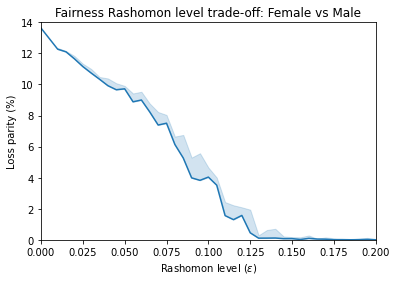

In [112]:
sns.lineplot(data=df, x=r'Rashomon level ($\epsilon$)', y=r'Loss parity (%)', estimator = 'min')
plt.xlim([0,0.2])
plt.ylim([0,14])
plt.title('Fairness Rashomon level trade-off: Female vs Male')
plt.savefig('Fairness_Rashomon _level_trade-off.pdf')

In [56]:
all_g= np.zeros(fair_gain.size + 1)
all_g[0] = 0.1363591596760535
all_g[1:] = fair_gain

plt.plot([0] + list(eps), 100*all_g, color = 'black')
plt.xlim([0,0.2])
plt.ylim([0, 15])
plt.xlabel(r'Rashomon level ($\epsilon$)')
plt.ylabel(r'Fairness Gain (%)')
plt.title('Fairness Rashomon level trade-off: Female vs Male')
plt.savefig('Fairness_Rashomon _level_trade-off.pdf')

ValueError: could not broadcast input array from shape (39,4000) into shape (156000,)

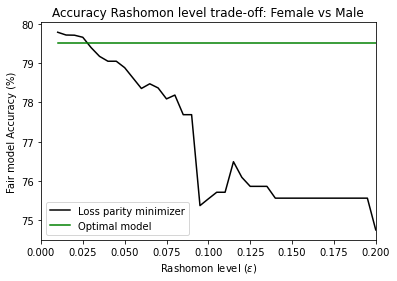

In [38]:
optimal_model_acc = np.mean(get_thresholded(get_ridge_prediction(omega_hat, X_train)) == Y_train)
plt.plot(eps, 100*ACC_loss, color = 'black', label = 'Loss parity minimizer')
plt.plot(eps, 100*optimal_model_acc*np.ones(ACC_loss.size), color = 'green', label = 'Optimal model')
plt.legend()

plt.xlim([0,0.2])
plt.xlabel(r'Rashomon level ($\epsilon$)')
plt.ylabel(r'Fair model Accuracy (%)')

plt.title('Accuracy Rashomon level trade-off: Female vs Male')
plt.savefig('Accuracy_Rashomon _level_trade-off.pdf')


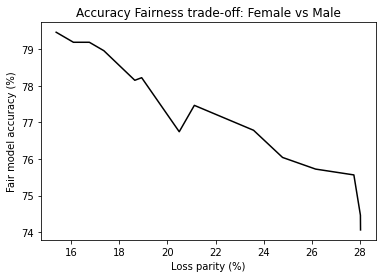

In [144]:
plt.plot(100*fair_gain+100*fairness_score(omega_hat, X_train, Y_train), 100*ACC_loss, color = 'black')

plt.ylabel(r'Fair model accuracy (%)')
plt.xlabel(r'Loss parity (%)')

plt.title('Accuracy Fairness trade-off: Female vs Male')
plt.savefig('Accuracy_Fairness_trade-off.pdf')